In [7]:
import math
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [5]:
h = 0.0000001
x = 3.0
(f(x + h) - f(x))/h

14.000000305713911

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [3]:
class Value:
    def __init__(self, data, label='', _children=(), _op=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label
        self._prev = set(_children)
        self._op = _op
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, '', (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, '', (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data ** other, '', (self, ), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, '', (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self): 
        x = self.data
        o = math.exp(x)
        out = Value(o, '', (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

    def __neg__(self):
        return self * (-1)
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self - other
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [147]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [15]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build (v):
        if v not in nodes:
            nodes.add(v)
            
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)   
    return nodes, edges

def draw_dot (root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape = 'record')

        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect nl to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

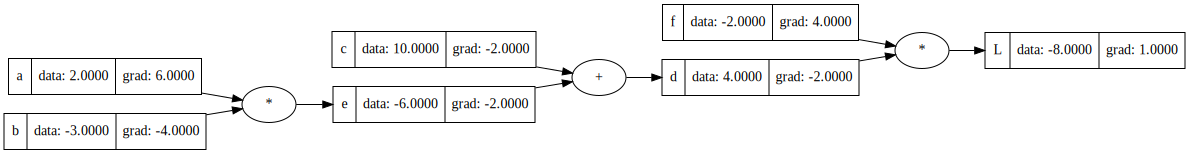

In [57]:
draw_dot(L)

In [56]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
c.grad = d.grad
e.grad = d.grad
a.grad = e.grad * b.data
b.grad = e.grad * a.data


In [60]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f

print(L.data)

-7.286496


In [59]:
def lol():
    
    h = 0.001

    a = Value(2.0, 'a')
    b = Value(-3.0, 'b')
    c = Value(10.0, 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, 'f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, 'a')
    b = Value(-3.0, 'b')
    b.data += h
    c = Value(10.0, 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, 'f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-3.9999999999995595


In [148]:
# inputs
x1 = Value(2.0, 'x1')
x2 = Value(0.0, 'x2')
# weights
w1 = Value(-3.0, 'w1')
w2 = Value(1.0, 'w2')
# bias of the neuron
b = Value(6.8813735870195432, 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

In [82]:
o.grad = 1.0
n.grad = 1 - o.data**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data

w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data

In [98]:
o._backward()
n._backward()
b._backward() # does nothing
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

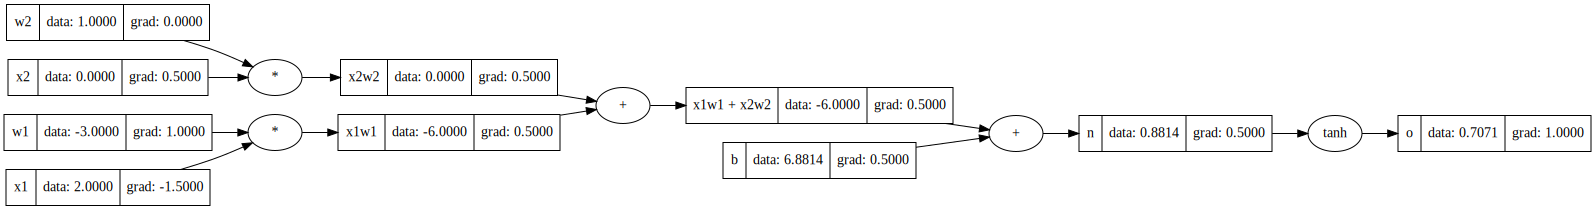

In [149]:
draw_dot(o)

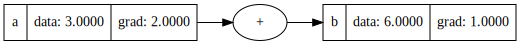

In [122]:
a = Value(3.0, 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

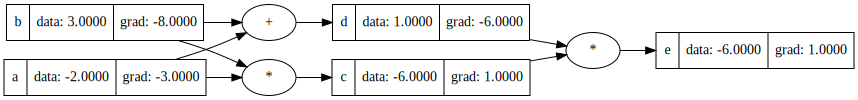

In [123]:
a = Value(-2.0, 'a')
b = Value(3.0, 'b')
c = a*b; c.label = 'c'
d = a+b; d.label = 'd'
e = c * d; e.label = 'e'
e.backward()
draw_dot(e)

In [151]:
x1 = torch.Tensor( [2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor( [0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor( [-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor( [1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('wl', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
wl 1.0000002567688737


In [18]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        # print(list((wi,xi) for wi, xi in zip(self.w, x)))
        act = sum(wi * xi for wi, xi in zip(self.w, x)) #+ self.b
        out = act.tanh()

        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [19]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.09795902873518064, grad=0.0)

In [118]:
n = MLP(3, [4, 4, 1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0,-1.0, 0.51],
    [0.5, 1.0, 1.0],
    [1.0,1.0, -1.01],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [112]:
[y.data for y in ypred]

[0.9975645457584817,
 -0.9944165549852232,
 -0.8108386476766692,
 0.9970900892373328]

In [107]:
ypred = [n(x) for x in xs]
loss = sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.03582759108903352, grad=0.0)

In [108]:
loss.backward()

In [109]:
for p in n.parameters():
    p.data += 0.01 * -p.grad

In [111]:
n.parameters()

[Value(data=0.7713181078946882, grad=-0.9555493892795625),
 Value(data=0.9719642001654281, grad=-0.3974609482913337),
 Value(data=-0.7396927491832723, grad=-0.7898466464233969),
 Value(data=0.8785568778716102, grad=0.0),
 Value(data=0.0015260224635962518, grad=0.3857952866357681),
 Value(data=0.8645233096013877, grad=1.15997176045826),
 Value(data=-0.44826846510647234, grad=1.029152433313095),
 Value(data=-0.1307993139853285, grad=0.0),
 Value(data=-0.09689660730494411, grad=1.4442650768527534),
 Value(data=0.6533417437371407, grad=2.287750564297385),
 Value(data=-0.21897000809721257, grad=2.643591321980956),
 Value(data=-0.7863220099165316, grad=0.0),
 Value(data=0.12444520358180147, grad=-0.6788432257767291),
 Value(data=0.5877261222444734, grad=0.20484020377016132),
 Value(data=-1.3725320705026471, grad=8.935365266027976),
 Value(data=0.47290422116999364, grad=0.0),
 Value(data=0.15925035871489573, grad=-2.3513714348005013),
 Value(data=0.079891267365819, grad=-2.966403017775918),
 

In [121]:
epochs = 50
for k in range(epochs):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update weights
    for p in n.parameters():
        p.data += 0.05 * -p.grad

    print(k, loss.data)

0 0.04618390692491488
1 0.0425459292555319
2 0.03941097521662974
3 0.036684078069275254
4 0.034292379296044506
5 0.03217912241367851
6 0.030299486748729367
7 0.028617640177809614
8 0.02710461692481826
9 0.02573676473613413
10 0.02449459197290758
11 0.023361900145580747
12 0.022325123202589326
13 0.021372818613981628
14 0.020495271295749087
15 0.01968418238772649
16 0.018932422523256005
17 0.018233834602876045
18 0.01758307491967196
19 0.016975484253439168
20 0.016406982572671085
21 0.015873982474630198
22 0.01537331760426587
23 0.014902183127214736
24 0.014458085964522962
25 0.014038802979857016
26 0.01364234568185315
27 0.013266930292576523
28 0.012910952258110177
29 0.012572964454094063
30 0.012251658478780958
31 0.011945848537277573
32 0.01165445750945943
33 0.011376504865429087
34 0.011111096150045473
35 0.010857413804847706
36 0.010614709133853121
37 0.010382295250958587
38 0.010159540872373467
39 0.00994586483873561
40 0.00974073126915466
41 0.009543645264065865
42 0.009354149086

In [122]:
ypred

[Value(data=0.9557756416553458, grad=-0.08844871668930843),
 Value(data=-0.9527837355645722, grad=0.09443252887085563),
 Value(data=-0.946818181446907, grad=0.10636363710618602),
 Value(data=0.9654362474821104, grad=-0.06912750503577914)]